<div style="line-height:0.5">
<h1 style="color:#FF7C00  ">  Feedforward Networks + K-fold validatation in Tensorflow  </h1>
<h4> Example base on the OnlineNewsPopularity dataset, with "data_channel_is_lifestyle" column as target to predict. </h4>

<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3>
    keras layers + MinMaxScaler + pd.api.types
</span>
</div>

In [2]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import sys
("Python version is", sys.version)
import sklearn
print("Scikit-learn version is: ", sklearn.__version__)
import tensorflow as tf
print("Tensorflow version is: ", tf.__version__)

Scikit-learn version is:  1.2.0
Tensorflow version is:  2.13.0


In [43]:
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from keras.utils import to_categorical

In [5]:
df = pd.read_csv("./datasets/OnlineNewsPopularity.csv")
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [6]:
df.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [7]:
print(df.describe().T)

                                  count           mean            std  \
 timedelta                      39644.0     354.530471     214.163767   
 n_tokens_title                 39644.0      10.398749       2.114037   
 n_tokens_content               39644.0     546.514731     471.107508   
 n_unique_tokens                39644.0       0.548216       3.520708   
 n_non_stop_words               39644.0       0.996469       5.231231   
 n_non_stop_unique_tokens       39644.0       0.689175       3.264816   
 num_hrefs                      39644.0      10.883690      11.332017   
 num_self_hrefs                 39644.0       3.293638       3.855141   
 num_imgs                       39644.0       4.544143       8.309434   
 num_videos                     39644.0       1.249874       4.107855   
 average_token_length           39644.0       4.548239       0.844406   
 num_keywords                   39644.0       7.223767       1.909130   
 data_channel_is_lifestyle      39644.0       0.052

<h2 style="color:#FF7C00  ">  Preprocessing </h2>

#### => Adjustment in dataset

In [8]:
""" Remove the extra initial space on the features names """
## Specify the file paths
input_file_path = './datasets/OnlineNewsPopularity.csv'
output_file_path = './datasets/OnlineNewsPopularity_fixed.csv'

## Input CSV file for reading
with open(input_file_path, 'r') as input_file:
    ## Read the first line (header) and remove the leading space
    header = input_file.readline().strip().split(',')
    header = [col.strip() for col in header]
    # Read the remaining lines
    lines = input_file.readlines()

# Output CSV file for writing
with open(output_file_path, 'w') as output_file:
    # Write the modified header
    output_file.write(','.join(header) + '\n')
    # Write the remaining lines
    output_file.writelines(lines)

In [9]:
df = pd.read_csv("./datasets/OnlineNewsPopularity_fixed.csv")
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [10]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

In [11]:
df['shares']

0         593
1         711
2        1500
3        1200
4         505
         ... 
39639    1800
39640    1900
39641    1900
39642    1100
39643    1300
Name: shares, Length: 39644, dtype: int64

In [12]:
df['shares'].dtype

dtype('int64')

In [13]:
df['title_subjectivity']

0        0.500000
1        0.000000
2        0.000000
3        0.000000
4        0.454545
           ...   
39639    0.100000
39640    0.300000
39641    0.454545
39642    0.000000
39643    0.333333
Name: title_subjectivity, Length: 39644, dtype: float64

In [14]:
set_title = set(list(df['title_subjectivity']))
len(set_title)

673

In [15]:
unique_title_subjectivity_values = df['title_subjectivity'].unique()
len(unique_title_subjectivity_values)

673

In [16]:
unique_title_subjectivity_values = df['data_channel_is_lifestyle'].unique()
len(unique_title_subjectivity_values)

2

In [17]:
df['data_channel_is_lifestyle'].iloc[:3]

0    0.0
1    0.0
2    0.0
Name: data_channel_is_lifestyle, dtype: float64

In [18]:
"""" Search for NaN values in each column of the DataFrame. """
print(df.isnull().sum())

url                             0
timedelta                       0
n_tokens_title                  0
n_tokens_content                0
n_unique_tokens                 0
                               ..
title_subjectivity              0
title_sentiment_polarity        0
abs_title_subjectivity          0
abs_title_sentiment_polarity    0
shares                          0
Length: 61, dtype: int64


In [19]:
# Change from float to int
df['data_channel_is_lifestyle'] = df['data_channel_is_lifestyle'].astype(int)

In [20]:
""" Check NaN values in each column of the DataFrame. """
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  float64
 2   n_tokens_title                 39644 non-null  float64
 3   n_tokens_content               39644 non-null  float64
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  float64
 8   num_self_hrefs                 39644 non-null  float64
 9   num_imgs                       39644 non-null  float64
 10  num_videos                     39644 non-null  float64
 11  average_token_length           39644 non-null  float64
 12  num_keywords                   39644 non-null 

In [21]:
df['data_channel_is_lifestyle'].value_counts()

0    37545
1     2099
Name: data_channel_is_lifestyle, dtype: int64

In [22]:
# Define the dependent variable to predict
y = df["data_channel_is_lifestyle"].values

In [23]:
##### Check if all float values in a column have zeros as decimal part, in order to convert them to int
for column in df.columns:
    # Check if the column contains numeric data
        if pd.api.types.is_numeric_dtype(df[column]):        
            if (df[column] == df[column].astype(int)).all():
                df[column] = df[column].astype(int)

In [24]:
# Define X set of independent variables and normalize values
X = df.drop(labels = ["data_channel_is_lifestyle"], axis=1) 

In [25]:
# Get the list of column names with data type 'int'
int_columns = X.select_dtypes(include=['int']).columns.tolist()

## Create a MinMaxScaler for the selected columns
scaler = MinMaxScaler()
scaler.fit(X[int_columns])

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  int64  
 2   n_tokens_title                 39644 non-null  int64  
 3   n_tokens_content               39644 non-null  int64  
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  int64  
 8   num_self_hrefs                 39644 non-null  int64  
 9   num_imgs                       39644 non-null  int64  
 10  num_videos                     39644 non-null  int64  
 11  average_token_length           39644 non-null  float64
 12  num_keywords                   39644 non-null 

In [26]:
# Remove useless URL column that should not be encoded and used in training
del X['url']

In [27]:
# Transform the selected columns using the scaler
X[int_columns] = scaler.transform(X[int_columns])

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      39644 non-null  float64
 1   n_tokens_title                 39644 non-null  float64
 2   n_tokens_content               39644 non-null  float64
 3   n_unique_tokens                39644 non-null  float64
 4   n_non_stop_words               39644 non-null  float64
 5   n_non_stop_unique_tokens       39644 non-null  float64
 6   num_hrefs                      39644 non-null  float64
 7   num_self_hrefs                 39644 non-null  float64
 8   num_imgs                       39644 non-null  float64
 9   num_videos                     39644 non-null  float64
 10  average_token_length           39644 non-null  float64
 11  num_keywords                   39644 non-null  float64
 12  data_channel_is_entertainment  39644 non-null 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  int64  
 2   n_tokens_title                 39644 non-null  int64  
 3   n_tokens_content               39644 non-null  int64  
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  int64  
 8   num_self_hrefs                 39644 non-null  int64  
 9   num_imgs                       39644 non-null  int64  
 10  num_videos                     39644 non-null  int64  
 11  average_token_length           39644 non-null  float64
 12  num_keywords                   39644 non-null 

<h2 style="color:#FF7C00  "> => NN model </h2>

<h3 style="color:#FF7C00 "> Recap:</h3>
<div style="margin-top: -8px";>
Sequential model is the simplest way to create a linear stack of layers where each layer has exactly one input tensor and one output tensor.

In [32]:
model = Sequential()
model.add(Dense(16, input_dim=59, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.add(Activation('sigmoid'))  
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                960       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 977 (3.82 KB)
Trainable params: 977 (3.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


2023-08-09 13:40:29.392501: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [33]:
# Number of unique classes in labels
num_classes = len(np.unique(y_train)) 

y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)
y_test_onehot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
%%script echo Skipping. Use y_train_onehot and y_test_onehot in model.fit()
history = model.fit(X_train, y_train_onehot, verbose=1, epochs=20, batch_size=64, validation_data=(X_test, y_test_onehot))

In [34]:
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(y_test)
type(y_train_tensor), type(y_test_tensor)

(tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

In [35]:
# Train
history = model.fit(X_train, y_train, verbose=1, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
465/465 [==============================] - 3s 4ms/step - loss: 1322.2212 - val_loss: 353.5991
Epoch 2/20
465/465 [==============================] - 2s 4ms/step - loss: 219.9911 - val_loss: 36.2387
Epoch 3/20
465/465 [==============================] - 1s 3ms/step - loss: 32.0647 - val_loss: 7.4278
Epoch 4/20
465/465 [==============================] - 1s 3ms/step - loss: 8.2183 - val_loss: 2.1003
Epoch 5/20
465/465 [==============================] - 1s 3ms/step - loss: 7.5963 - val_loss: 2.3179
Epoch 6/20
465/465 [==============================] - 1s 3ms/step - loss: 4.1330 - val_loss: 4.5328
Epoch 7/20
465/465 [==============================] - 1s 3ms/step - loss: 2.6977 - val_loss: 2.4201
Epoch 8/20
465/465 [==============================] - 1s 3ms/step - loss: 1.8813 - val_loss: 4.2793
Epoch 9/20
465/465 [==============================] - 1s 3ms/step - loss: 1.6249 - val_loss: 1.6838
Epoch 10/20
465/465 [==============================] - 1s 3ms/step - loss: 0.7632 - val_los

In [36]:
result = model.evaluate(X_test, y_test)

310/310 [==============================] - 1s 2ms/step - loss: 0.2471


In [37]:
""" N.B. #TypeError: cannot unpack non-iterable float object """
# _, acc = model.evaluate(X_test, y_test)

' N.B. #TypeError: cannot unpack non-iterable float object '

In [38]:
if isinstance(result, tuple) and len(result) == 2:
    loss, acc = result
    print("Loss:", loss)
    print("Accuracy:", acc)
else:
    print("Evaluation result:", result)

Evaluation result: 0.24710556864738464


In [39]:
y_pred_train = model.predict(X_train)
# Convert the predictions to class labels
y_pred_class_train = np.round(y_pred_train)
# Calculate the accuracy
train_accuracy = accuracy_score(y_train, y_pred_class_train)

y_pred_test = model.predict(X_test)
y_pred_class_test = np.round(y_pred_test)
test_accuracy = accuracy_score(y_test, y_pred_class_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

310/310 [==============================] - 1s 2ms/step
Train Accuracy: 0.9472976154441193
Test Accuracy: 0.946322268186863


In [40]:
history.history

{'loss': [1322.22119140625,
  219.99107360839844,
  32.06472396850586,
  8.218255043029785,
  7.5963134765625,
  4.132995128631592,
  2.697669267654419,
  1.8813385963439941,
  1.6249442100524902,
  0.7631946206092834,
  0.5117043852806091,
  0.5321057438850403,
  0.36742591857910156,
  0.28149428963661194,
  0.2765955924987793,
  0.2864936590194702,
  0.267978310585022,
  0.21978731453418732,
  0.20729932188987732,
  0.20175272226333618],
 'val_loss': [353.59912109375,
  36.238739013671875,
  7.427818298339844,
  2.100341558456421,
  2.317894697189331,
  4.532751083374023,
  2.420063018798828,
  4.279314994812012,
  1.68384850025177,
  0.37977197766304016,
  0.27943697571754456,
  1.3349189758300781,
  0.2913823127746582,
  0.5017456412315369,
  0.29677870869636536,
  0.27715006470680237,
  0.2548787593841553,
  0.25340405106544495,
  0.2557743489742279,
  0.24710553884506226]}

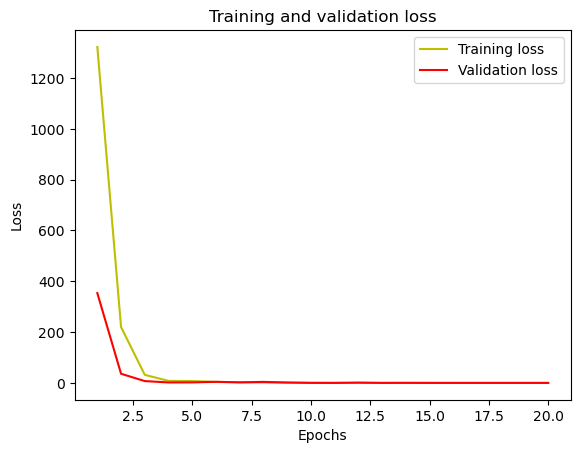

In [41]:
""" Plot the training and validation accuracy and loss at each epoch. """
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

310/310 [==============================] - 0s 2ms/step


<Axes: >

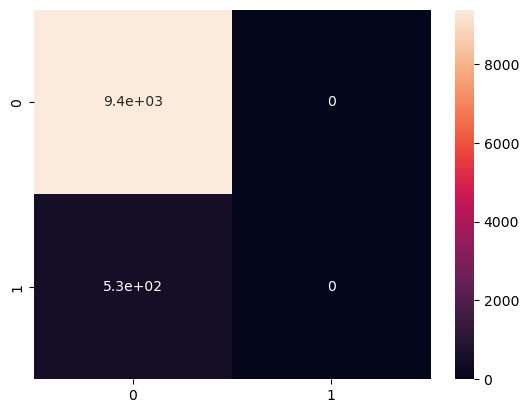

In [42]:
""" Preduct results on the test set.
N.B.
Convert the predicted probabilities into binary class labels, 
to avoid the error : ValueError: Classification metrics can't handle a mix of binary and continuous targets
"""
y_pred_test = model.predict(X_test)
y_pred_test = (y_pred_test > 0.5)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True)

In [45]:
scores = []
num_folds = 5
# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

### Split the data in each fold into training and test sets
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ###### Build model
    model = Sequential()
    model.add(Dense(16, input_dim=59, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')

    # Train the model for 20 epochs
    history = model.fit(X_train, y_train, verbose=1, epochs=20, batch_size=64, validation_data=(X_test, y_test))

    # Evaluate the model on the test set for this fold
    result = model.evaluate(X_test, y_test)
    scores.append(result)

Epoch 1/20
496/496 [==============================] - 2s 3ms/step - loss: 943.2370 - val_loss: 126.6329
Epoch 2/20
496/496 [==============================] - 1s 3ms/step - loss: 54.4710 - val_loss: 5.0200
Epoch 3/20
496/496 [==============================] - 2s 3ms/step - loss: 13.8180 - val_loss: 2.8931
Epoch 4/20
496/496 [==============================] - 1s 3ms/step - loss: 4.8393 - val_loss: 1.4316
Epoch 5/20
496/496 [==============================] - 1s 3ms/step - loss: 5.7657 - val_loss: 0.7787
Epoch 6/20
496/496 [==============================] - 1s 3ms/step - loss: 3.0287 - val_loss: 0.2535
Epoch 7/20
496/496 [==============================] - 1s 3ms/step - loss: 2.1928 - val_loss: 0.2194
Epoch 8/20
496/496 [==============================] - 1s 3ms/step - loss: 1.8564 - val_loss: 0.5619
Epoch 9/20
496/496 [==============================] - 1s 3ms/step - loss: 1.0549 - val_loss: 0.1880
Epoch 10/20
496/496 [==============================] - 1s 3ms/step - loss: 0.3783 - val_loss: 

In [46]:
""" Print scores for each fold. """
for i, score in enumerate(scores):
    print("Fold {}: {}".format(i+1, score))

mean_score = np.mean(scores)
std_score = np.std(scores)
print("Mean score: {}".format(mean_score))
print("Standard deviation: {}".format(std_score))

Fold 1: 0.18731218576431274
Fold 2: 0.4036012887954712
Fold 3: 0.2790919244289398
Fold 4: 0.1992952972650528
Fold 5: 0.2769138216972351
Mean score: 0.2692429035902023
Standard deviation: 0.07721830356222252
